In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import glob
import os
from matplotlib.animation import FFMpegWriter

In [2]:
def get_grid_values_with_primitives(dump_file):
    """
    Read Boyer-Lindquist coordinates and primitive variables from a HARM dump file.
    
    Returns:
    --------
    r_BL, th_BL : ndarray of shape (N1, N2)
        Boyer-Lindquist coordinates (already computed in file)
    rho, uu, u1, u2, u3, b1, b2, b3 : ndarray of shape (N1, N2)
        Primitive variables at each grid point
    """

    with open(dump_file, 'r') as fp:
        header_line = fp.readline().split()
        
        N1 = int(header_line[1])
        N2 = int(header_line[2])
        
        # Initialize arrays
        r_BL = np.zeros((N1, N2))
        th_BL = np.zeros((N1, N2))
        rho = np.zeros((N1, N2))
        uu = np.zeros((N1, N2))
        u1 = np.zeros((N1, N2))
        u2 = np.zeros((N1, N2))
        u3 = np.zeros((N1, N2))
        b1 = np.zeros((N1, N2))
        b2 = np.zeros((N1, N2))
        b3 = np.zeros((N1, N2))
        
        for i in range(N1):
            for j in range(N2):
                line = fp.readline()
                
                if not line and i == N1-1 and j == N2-1:
                    break
                    
                parts = line.split()
                
                # Dump format: X[1], X[2], r, th, p[RHO], p[UU], p[U1], p[U2], p[U3], p[B1], p[B2], p[B3], ...
                # Index:       0      1     2   3    4        5       6       7       8        9      10     11
                
                r_BL[i, j] = float(parts[2])   # r (already in BL coords)
                th_BL[i, j] = float(parts[3])  # th (already in BL coords)
                
                # Primitive variables start at index 4
                rho[i, j] = float(parts[4])
                uu[i, j] = float(parts[5])
                u1[i, j] = float(parts[6])
                u2[i, j] = float(parts[7])
                u3[i, j] = float(parts[8])
                b1[i, j] = float(parts[9])
                b2[i, j] = float(parts[10])
                b3[i, j] = float(parts[11])
        
        print(f"Grid dimensions: N1={N1}, N2={N2}")
        print(f"r_BL range: [{r_BL.min():.4f}, {r_BL.max():.4f}]")
        print(f"th_BL range (rad): [{th_BL.min():.4f}, {th_BL.max():.4f}]")
        print(f"th_BL range (deg): [{np.degrees(th_BL.min()):.2f}, {np.degrees(th_BL.max()):.2f}]")
        print(f"rho range: [{rho.min():.4e}, {rho.max():.4e}]")
        print(f"uu range: [{uu.min():.4e}, {uu.max():.4e}]")
        
        return r_BL, th_BL, rho, uu, u1, u2, u3, b1, b2, b3

In [3]:
# Read coordinates - get_grid_ranges returns the full arrays via read_dump_coordinates
latest_dump = 'dumps/dump000'

# Read all data
r_BL, th_BL, rho, uu, u1, u2, u3, b1, b2, b3 = get_grid_values_with_primitives(latest_dump)

# Now you can plot any variable
s_BL = r_BL*np.sin(th_BL)
z_BL = r_BL*np.cos(th_BL)

Grid dimensions: N1=256, N2=256
r_BL range: [1.3299, 39.7344]
th_BL range (rad): [0.0104, 3.1312]
th_BL range (deg): [0.60, 179.40]
rho range: [3.9925e-07, 1.0000e+00]
uu range: [1.0048e-10, 1.2962e-02]


/tmp/ipykernel_1916933/140673197.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(s_BL, z_BL, np.log10(rho), shading='auto', cmap='viridis')


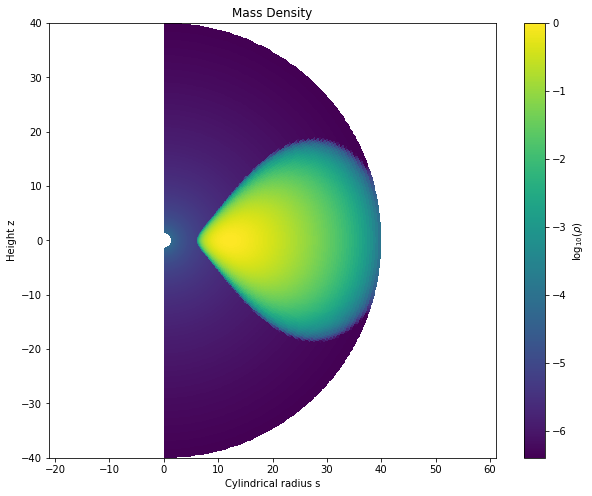

In [4]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(s_BL, z_BL, np.log10(rho), shading='auto', cmap='viridis')
plt.colorbar(label=r'$\log_{10}(\rho)$')
plt.xlabel('Cylindrical radius s')
plt.ylabel('Height z')
plt.title('Mass Density')
plt.axis('equal')
plt.show()

In [5]:
def create_movie_from_dumps(dump_dir='dumps', dump_prefix='dump', 
                           variable='rho', output_file='movie.mp4',
                           vmin=None, vmax=None, cmap='viridis',
                           log_scale=True, fps=10):
    """
    Create a movie from dump files showing the evolution of a variable.
    
    Parameters:
    -----------
    dump_dir : str
        Directory containing dump files
    dump_prefix : str
        Prefix of dump files (e.g., 'dump' for dump000, dump001, ...)
    variable : str
        Variable to plot: 'rho', 'uu', 'u1', 'u2', 'u3', 'b1', 'b2', 'b3'
    output_file : str
        Output movie filename (e.g., 'rho_evolution.mp4')
    vmin, vmax : float, optional
        Color scale limits. If None, auto-scales for each frame
    cmap : str
        Matplotlib colormap name
    log_scale : bool
        Whether to plot log10 of the variable
    fps : int
        Frames per second in output movie
    
    Returns:
    --------
    None (saves movie to output_file)
    """
    
    # Find all dump files
    dump_pattern = os.path.join(dump_dir, f'{dump_prefix}*')
    dump_files = sorted(glob.glob(dump_pattern))
    
    if len(dump_files) == 0:
        raise ValueError(f"No dump files found matching {dump_pattern}")
    
    print(f"Found {len(dump_files)} dump files")
    print(f"Creating movie of {variable}...")
    
    # Read first file to get grid info and determine color scale
    print("Reading first dump to set up grid...")
    with open(dump_files[0], 'r') as fp:
        header_line = fp.readline().split()
        N1 = int(header_line[1])
        N2 = int(header_line[2])
        hslope = float(header_line[24])
        R0 = float(header_line[25])
    
    # Initialize coordinate arrays (only need to do once)
    r_BL = np.zeros((N1, N2))
    th_BL = np.zeros((N1, N2))
    
    # If vmin/vmax not specified, scan all files to find range
    if vmin is None or vmax is None:
        print("Scanning all dumps to find variable range...")
        all_values = []
        
        for dump_file in dump_files:
            with open(dump_file, 'r') as fp:
                header_line = fp.readline().split()
                var_data = np.zeros((N1, N2))
                
                for i in range(N1):
                    for j in range(N2):
                        line = fp.readline()
                        if not line and i == N1-1 and j == N2-1:
                            break
                        parts = line.split()
                        
                        # Map variable name to column index
                        var_indices = {
                            'rho': 4, 'uu': 5, 'u1': 6, 'u2': 7,
                            'u3': 8, 'b1': 9, 'b2': 10, 'b3': 11
                        }
                        var_data[i, j] = float(parts[var_indices[variable]])
                
                if log_scale:
                    var_data = np.log10(var_data + 1e-20)  # Add small value to avoid log(0)
                all_values.append(var_data)
        
        all_values = np.concatenate([v.ravel() for v in all_values])
        if vmin is None:
            # vmin = np.percentile(all_values, 1)  # Use 1st percentile to avoid outliers
            vmin = min(all_values)
        if vmax is None:
            # vmax = np.percentile(all_values, 99)  # Use 99th percentile
            vmax = max(all_values)
        
        print(f"Color scale: [{vmin:.2f}, {vmax:.2f}]")
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Set up movie writer
    writer = FFMpegWriter(fps=fps, metadata=dict(artist='HARM'), bitrate=1800)
    
    output_file = "vids/" + output_file
    with writer.saving(fig, output_file, dpi=100):
        for idx, dump_file in enumerate(dump_files):
            print(f"Processing frame {idx+1}/{len(dump_files)}: {os.path.basename(dump_file)}")
            
            with open(dump_file, 'r') as fp:
                header_line = fp.readline().split()
                
                t = float(header_line[0])
                N1 = int(header_line[1])
                N2 = int(header_line[2])
                hslope = float(header_line[24])
                R0 = float(header_line[25])
                
                var_data = np.zeros((N1, N2))
                
                for i in range(N1):
                    for j in range(N2):
                        line = fp.readline()
                        if not line and i == N1-1 and j == N2-1:
                            break
                        parts = line.split()
                        
                        X1 = float(parts[0])
                        X2 = float(parts[1])
                        
                        # Compute coordinates only on first frame
                        if idx == 0:
                            r_BL[i, j] = float(parts[2])
                            th_BL[i, j] = float(parts[3])
                        
                        # Map variable name to column index
                        var_indices = {
                            'rho': 4, 'uu': 5, 'u1': 6, 'u2': 7,
                            'u3': 8, 'b1': 9, 'b2': 10, 'b3': 11
                        }
                        var_data[i, j] = float(parts[var_indices[variable]])
            
            # Convert to cylindrical coordinates
            s_BL = r_BL * np.sin(th_BL)
            z_BL = r_BL * np.cos(th_BL)
            
            # Apply log scale if requested
            if log_scale:
                var_data = np.log10(var_data + 1e-20)
                var_label = f'$\\log_{{10}}({variable})$'
            else:
                var_label = variable
            
            # Clear and plot
            ax.clear()
            im = ax.pcolormesh(s_BL, z_BL, var_data, shading='auto', 
                              cmap=cmap, vmin=vmin, vmax=vmax)
            
            if idx == 0:  # Add colorbar only once
                plt.colorbar(im, ax=ax, label=var_label)
            
            ax.set_xlabel(r'Cylindrical radius $s$ $(r_g)$')
            ax.set_ylabel(r'Height $z$ $(r_g)$')
            ax.set_title(f'{variable} at t = {t:.2f} $(r_g/c)$')
            ax.set_aspect('equal')
            ax.set_xlim(0, 30)
            ax.set_ylim(-30, 30)
            
            writer.grab_frame()
    
    print(f"Movie saved to {output_file}")
    plt.close(fig)

In [6]:
# Density evolution
# create_movie_from_dumps(variable='rho', output_file='rho_evolution.mp4')

# # Velocity components
# create_movie_from_dumps(variable='u1', output_file='u1_evolution.mp4')
# create_movie_from_dumps(variable='u2', output_file='u2_evolution.mp4')
# create_movie_from_dumps(variable='u3', output_file='u3_evolution.mp4')

# # Magnetic fields
# create_movie_from_dumps(variable='b1', output_file='b1_evolution.mp4')
# create_movie_from_dumps(variable='b2', output_file='b2_evolution.mp4')
# create_movie_from_dumps(variable='b3', output_file='b3_evolution.mp4')

In [7]:
def plot_flux_with_density(dump_file, a=0.9375, rho_cmap='viridis',
                           rho_vmin=None, rho_vmax=None):
    """
    Plot magnetic flux contours over log10 density background.
    """
    with open(dump_file, 'r') as fp:
        header_line = fp.readline().split()
        N1 = int(header_line[1])
        N2 = int(header_line[2])

        r_BL = np.zeros((N1, N2))
        th_BL = np.zeros((N1, N2))
        rho = np.zeros((N1, N2))
        b1 = np.zeros((N1, N2))
        gdet = np.zeros((N1, N2))

        for i in range(N1):
            for j in range(N2):
                line = fp.readline()
                if not line:
                    break
                parts = line.split()

                r_BL[i, j] = float(parts[2])
                th_BL[i, j] = float(parts[3])
                rho[i, j] = float(parts[4])
                b1[i, j] = float(parts[9])
                gdet[i, j] = float(parts[33])  # sqrt(-g)

    s_BL = r_BL * np.sin(th_BL)
    z_BL = r_BL * np.cos(th_BL)

    Sigma = r_BL**2 + a**2 * np.cos(th_BL)**2
    alpha = np.sqrt(Sigma / (Sigma + 2 * r_BL))
    sqrt_gamma = gdet / alpha

    # Phi(r, theta) = ∫_0^theta B^r sqrt(gamma) dtheta
    phi_2d = np.zeros((N1, N2))
    dtheta = np.abs(th_BL[0, 1] - th_BL[0, 0])
    for i in range(N1):
        for j in range(N2):
            integrand = b1[i, :j+1] * sqrt_gamma[i, :j+1]
            phi_2d[i, j] = np.trapz(integrand, dx=dtheta)

    log_rho = np.log10(rho + 1e-20)

    minAphi = 0.0001 #np.quantile(phi_2d, .11)
    maxAphi = np.max(phi_2d) #np.quantile(phi_2d, 0.9)
    clevels = np.linspace(minAphi, maxAphi, 10)
    

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.pcolormesh(s_BL, z_BL, log_rho, shading='auto',
                       cmap=rho_cmap, vmin=rho_vmin, vmax=rho_vmax)
    plt.colorbar(im, ax=ax, label=r'$\log_{10}(\rho)$')

    ax.contour(s_BL, z_BL, phi_2d, levels=clevels,
                         colors='mediumvioletred', linewidths=1.2)
    # ax.clabel(contour, inline=True, fontsize=7, fmt='%.2e')

    ax.set_xlabel(r'Cylindrical radius $s$ $(r_g)$')
    ax.set_ylabel(r'Height $z$ $(r_g)$')
    ax.set_title(r'Density with Magnetic Flux $\Phi$ Contours')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



/tmp/ipykernel_1916933/838690613.py:53: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(s_BL, z_BL, log_rho, shading='auto',


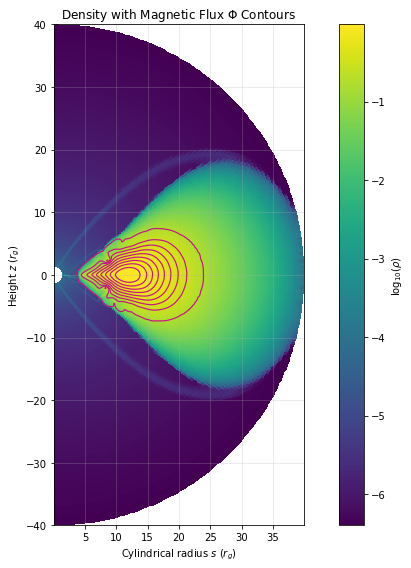

In [8]:
plot_flux_with_density('dumps/dump040')

In [58]:
def create_flux_density_movie(dump_dir='dumps', dump_prefix='dump', 
                              output_file='flux_density_evolution.mp4',
                              a=0.9375, levels=10, rho_cmap='viridis',
                              rho_vmin=None, rho_vmax=None, fps=10):
    """
    Create a movie showing magnetic flux contours over density background.
    
    Parameters:
    -----------
    dump_dir : str
        Directory containing dump files
    dump_prefix : str
        Prefix of dump files
    output_file : str
        Output movie filename
    a : float
        Black hole spin parameter
    levels : int
        Number of flux contour levels
    rho_cmap : str
        Colormap for density background
    rho_vmin, rho_vmax : float, optional
        Density color scale limits
    fps : int
        Frames per second
    """
    
    # Find all dump files
    dump_pattern = os.path.join(dump_dir, f'{dump_prefix}*')
    dump_files = sorted(glob.glob(dump_pattern))
    
    if len(dump_files) == 0:
        raise ValueError(f"No dump files found matching {dump_pattern}")
    
    print(f"Found {len(dump_files)} dump files")
    print(f"Creating flux+density movie...")
    
    # Read first file to get grid dimensions
    with open(dump_files[0], 'r') as fp:
        header_line = fp.readline().split()
        N1 = int(header_line[1])
        N2 = int(header_line[2])
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    writer = FFMpegWriter(fps=fps, metadata=dict(artist='HARM'), bitrate=1800)
    
    output_path = os.path.join('vids', output_file)
    os.makedirs('vids', exist_ok=True)
    
    with writer.saving(fig, output_path, dpi=100):
        for idx, dump_file in enumerate(dump_files):
            print(f"Processing frame {idx+1}/{len(dump_files)}: {os.path.basename(dump_file)}")
            
            with open(dump_file, 'r') as fp:
                header_line = fp.readline().split()
                t = float(header_line[0])
                
                r_BL = np.zeros((N1, N2))
                th_BL = np.zeros((N1, N2))
                rho = np.zeros((N1, N2))
                b1 = np.zeros((N1, N2))
                gdet = np.zeros((N1, N2))
                
                for i in range(N1):
                    for j in range(N2):
                        line = fp.readline()
                        if not line:
                            break
                        parts = line.split()
                        
                        r_BL[i, j] = float(parts[2])
                        th_BL[i, j] = float(parts[3])
                        rho[i, j] = float(parts[4])
                        b1[i, j] = float(parts[9])
                        gdet[i, j] = float(parts[33])
            
            # Compute coordinates and flux
            s_BL = r_BL * np.sin(th_BL)
            z_BL = r_BL * np.cos(th_BL)
            
            Sigma = r_BL**2 + a**2 * np.cos(th_BL)**2
            alpha = np.sqrt(Sigma / (Sigma + 2 * r_BL))
            sqrt_gamma = gdet / alpha
            
            # Compute flux
            phi_2d = np.zeros((N1, N2))
            dtheta = np.abs(th_BL[0, 1] - th_BL[0, 0])
            for i in range(N1):
                for j in range(N2):
                    integrand = b1[i, :j+1] * sqrt_gamma[i, :j+1]
                    phi_2d[i, j] = np.trapz(integrand, dx=dtheta)
            
            log_rho = np.log10(rho + 1e-20)
            
            # Set up contour levels
            minAphi = 0.00001 #np.quantile(phi_2d, 0.1)
            maxAphi = np.quantile(phi_2d, 0.9)
            clevels = np.linspace(minAphi, maxAphi, levels)
            
            # Plot
            ax.clear()
            im = ax.pcolormesh(s_BL, z_BL, log_rho, shading='auto',
                              cmap=rho_cmap, vmin=rho_vmin, vmax=rho_vmax)
            
            ax.contour(s_BL, z_BL, phi_2d, levels=clevels,
                                colors='mediumvioletred', linewidths=1.2)
            # ax.clabel(contour, inline=True, fontsize=7, fmt='%.2e')
            
            if idx == 0:
                plt.colorbar(im, ax=ax, label=r'$\log_{10}(\rho)$')
            
            ax.set_xlabel(r'Cylindrical radius $s$ $(r_g)$')
            ax.set_ylabel(r'Height $z$ $(r_g)$')
            ax.set_title(f'Density with Magnetic Flux at t = {t:.2f}')
            ax.set_aspect('equal')
            ax.grid(True, alpha=0.3)
            
            writer.grab_frame()
    
    print(f"Movie saved to {output_path}")
    plt.close(fig)

In [59]:
create_flux_density_movie(output_file='flux_density_evolution.mp4', levels=10, fps=10)

Found 171 dump files
Creating flux+density movie...
Processing frame 1/171: dump000


/tmp/ipykernel_1821587/547293901.py:103: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(s_BL, z_BL, log_rho, shading='auto',


Processing frame 2/171: dump001
Processing frame 3/171: dump002
Processing frame 4/171: dump003
Processing frame 5/171: dump004
Processing frame 6/171: dump005
Processing frame 7/171: dump006
Processing frame 8/171: dump007
Processing frame 9/171: dump008
Processing frame 10/171: dump009
Processing frame 11/171: dump010
Processing frame 12/171: dump011
Processing frame 13/171: dump012
Processing frame 14/171: dump013
Processing frame 15/171: dump014
Processing frame 16/171: dump015
Processing frame 17/171: dump016
Processing frame 18/171: dump017
Processing frame 19/171: dump018
Processing frame 20/171: dump019
Processing frame 21/171: dump020
Processing frame 22/171: dump021
Processing frame 23/171: dump022
Processing frame 24/171: dump023
Processing frame 25/171: dump024
Processing frame 26/171: dump025
Processing frame 27/171: dump026
Processing frame 28/171: dump027
Processing frame 29/171: dump028
Processing frame 30/171: dump029
Processing frame 31/171: dump030
Processing frame 3